In [10]:
# import Pkg; Pkg.add(url="https://github.com/Red-Portal/SteinDiscrepancy.jl.git")
using Random, Distributions, RData

In [11]:
# import the kernel stein discrepancy function and kernel to use
using SteinDiscrepancy: SteinInverseMultiquadricKernel, ksd
# create the kernel instance
kernel = SteinInverseMultiquadricKernel()

SteinInverseMultiquadricKernel(0.5, 1.0)

In [12]:
# # import the kernel stein discrepancy function and kernel to use
# using SteinDiscrepancy: SteinInverseMultiquadricKernel, ksd
# # create the kernel instance
# kernel = SteinInverseMultiquadricKernel()
# # compute the KSD2
# result = ksd(points=samples, gradlogdensity=gradlogp, kernel=kernel)
# # get the final ksd
# kernel_stein_discrepancy = sqrt(result.discrepancy2)

In [13]:
half_t_data = load("/Users/niloybiswas/Google Drive/My Drive/Niloy_Files/github/BackUpFiles/CoupledHalfT_old/examples/big_data_examples/stein_chain_data.RData");
X = load("/Users/niloybiswas/Google Drive/My Drive/Niloy_Files/github/BackUpFiles/CoupledHalfT_old/examples/big_data_examples/stein_X.RData");
y = load("/Users/niloybiswas/Google Drive/My Drive/Niloy_Files/github/BackUpFiles/CoupledHalfT_old/examples/big_data_examples/stein_y.RData");

y = y["y"];
X = X["X"];
X_transpose = transpose(X);

n = size(X)[1];
p = size(X)[2];

# Prior
t_dist_df = 2;
a0 = 1;
b0 = 1;

nchains = length(half_t_data["half_t_chains"])
chain_length = size(half_t_data["half_t_chains"][1]["eta_samples"])[1]

# # Generate synthetic data
# n = 100
# p = 200
# s = 10
# true_beta = zeros((p,1))
# true_beta[1:s,] = 2 .^ (-([1:1:s;]/4 .- (9/4)))
# X = randn(n, p)
# X_transpose = transpose(X)

# # Error terms
# error_std = 0.5
# error_terms = error_std.*randn(n, 1)
# y = X * true_beta + error_terms;

# # Prior
# t_dist_df = 2;
# a0 = 1;
# b0 = 1;

In [14]:
# define the grad log density of half-t posterior
function gradlogp(eta_beta_xi_sigma2::Vector{Float64})
    eta = eta_beta_xi_sigma2[1:p];
    beta = eta_beta_xi_sigma2[(p+1):(2p)];
    xi = eta_beta_xi_sigma2[(2p+1):(2p+1)];
    sigma2 = eta_beta_xi_sigma2[(2p+2):(2p+2)];
    
    grad_eta = -(beta.*beta).*xi./(2*sigma2)+(1 ./ eta)*((t_dist_df - 1)/2)-(1 ./ (1 .+ t_dist_df .* eta))*((t_dist_df + 1)/2);
    grad_beta = (X_transpose * (y-X*beta) - (beta.*eta).*xi)./(sigma2);
    grad_beta = vec(grad_beta);
    grad_xi = -1 ./ (1 .+ xi) + ((p-1) ./ 2) ./ xi - sum(beta.*beta.*eta)./(2 .* sigma2);
    grad_sigma2 = -((n+p+a0)/2 +1)*(1 ./ sigma2) + (sum((y-X*beta).^2) .+ b0 .+ sum(beta.*beta.*eta).*xi)./(2*(sigma2.^2));
    output = vcat(grad_eta,grad_beta,grad_xi,grad_sigma2);
    output
end

gradlogp (generic function with 1 method)

In [15]:
# Check if E[gradlogp(X_t)] close to zero for large t
t=chain_length
samples = 
transpose(vcat(vec(half_t_data["half_t_chains"][1]["eta_samples"][t,:]), vec(half_t_data["half_t_chains"][1]["beta_samples"][t,:]),
        vec(half_t_data["half_t_chains"][1]["xi_samples"][t,:]), vec(half_t_data["half_t_chains"][1]["sigma2_samples"][t,:])));
for i in [2:1:nchains;]
    sample1 = transpose(vcat(vec(half_t_data["half_t_chains"][i]["eta_samples"][t,:]), vec(half_t_data["half_t_chains"][i]["beta_samples"][t,:]),
            vec(half_t_data["half_t_chains"][i]["xi_samples"][t,:]), vec(half_t_data["half_t_chains"][i]["sigma2_samples"][t,:])))
    samples = vcat(samples, sample1)
end

In [16]:
grads = zeros((nchains, (2*p+2)))
for i in [1:1:nchains;]
    grads[i,:] = gradlogp(samples[i,:])
end
# gradlogp(samples[10,:])

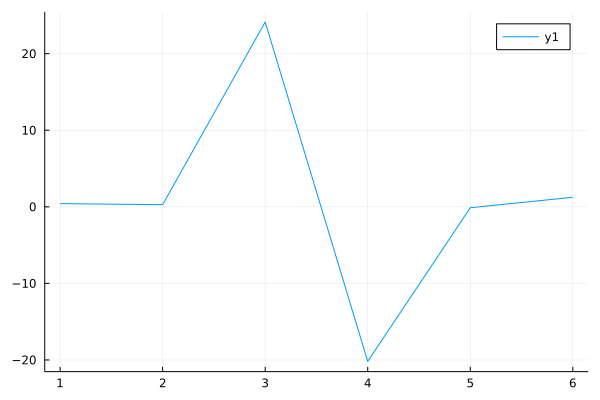

In [17]:
using Statistics, Plots

plot([1:1:(2*p+2);], vec(mean(grads, dims=1)))

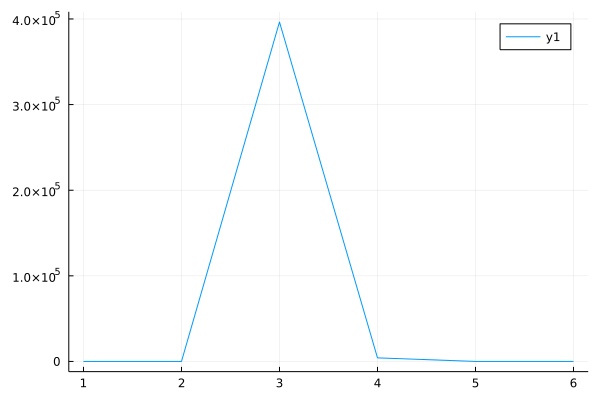

In [18]:
plot([1:1:(2*p+2);], vec(var(grads, dims=1)./(nchains).^0.5))

In [21]:
t=chain_length
samples = 
transpose(vcat(vec(half_t_data["half_t_chains"][1]["eta_samples"][t,:]), vec(half_t_data["half_t_chains"][1]["beta_samples"][t,:]),
        vec(half_t_data["half_t_chains"][1]["xi_samples"][t,:]), vec(half_t_data["half_t_chains"][1]["sigma2_samples"][t,:])));
for i in [2:1:nchains;]
    sample1 = transpose(vcat(vec(half_t_data["half_t_chains"][i]["eta_samples"][t,:]), vec(half_t_data["half_t_chains"][i]["beta_samples"][t,:]),
            vec(half_t_data["half_t_chains"][i]["xi_samples"][t,:]), vec(half_t_data["half_t_chains"][i]["sigma2_samples"][t,:])))
    samples = vcat(samples, sample1)
end

# compute the KSD2
result = ksd(points=samples, gradlogdensity=gradlogp, kernel=kernel)
# get the final ksd
kernel_stein_discrepancy = sqrt(result.discrepancy2);
ksd_over_time[t] = kernel_stein_discrepancy;
print(t)

500

In [19]:
nchains = length(half_t_data["half_t_chains"])
chain_length = size(half_t_data["half_t_chains"][1]["eta_samples"])[1]

ksd_over_time = zeros(chain_length)

for t in [1:1:chain_length;]
    samples = 
    transpose(vcat(vec(half_t_data["half_t_chains"][1]["eta_samples"][t,:]), vec(half_t_data["half_t_chains"][1]["beta_samples"][t,:]),
            vec(half_t_data["half_t_chains"][1]["xi_samples"][t,:]), vec(half_t_data["half_t_chains"][1]["sigma2_samples"][t,:])));
    for i in [2:1:nchains;]
        sample1 = transpose(vcat(vec(half_t_data["half_t_chains"][i]["eta_samples"][t,:]), vec(half_t_data["half_t_chains"][i]["beta_samples"][t,:]),
                vec(half_t_data["half_t_chains"][i]["xi_samples"][t,:]), vec(half_t_data["half_t_chains"][i]["sigma2_samples"][t,:])))
        samples = vcat(samples, sample1)
    end
    
    # compute the KSD2
    result = ksd(points=samples, gradlogdensity=gradlogp, kernel=kernel)
    # get the final ksd
    kernel_stein_discrepancy = sqrt(result.discrepancy2);
    ksd_over_time[t] = kernel_stein_discrepancy;
    print(t)
end



1234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495969798991001011021031041051061071081091101111121131141151161171181191201211221231241251261271281291301311321331341351361371381391401411421431441451461471481491501511521531541551561571581591601611621631641651661671681691701711721731741751761771781791801811821831841851861871881891901911921931941951961971981992002012022032042052062072082092102112122132142152162172182192202212222232242252262272282292302312322332342352362372382392402412422432442452462472482492502512522532542552562572582592602612622632642652662672682692702712722732742752762772782792802812822832842852862872882892902912922932942952962972982993003013023033043053063073083093103113123133143153163173183193203213223233243253263273283293303313323333343353363373383393403413423433443453463473483493503513523533543553563573583593603613623633643653663673683693

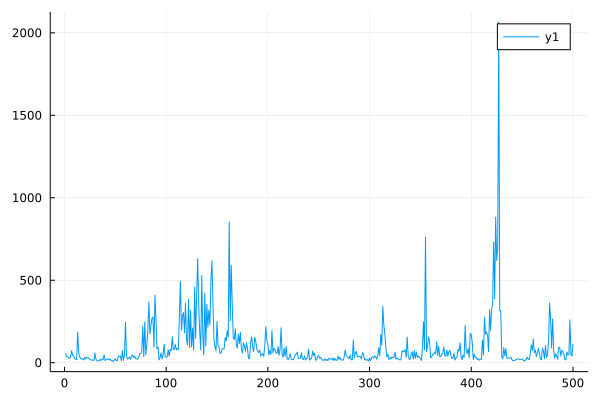

In [20]:
using Plots
plot([1:1:chain_length;], ksd_over_time[1:chain_length])

In [33]:
# ksd_over_time[1:chain_length]
# ksd_over_time

LoadError: ArgumentError: 'Vector{Float64}' iterates 'Float64' values, which doesn't satisfy the Tables.jl `AbstractRow` interface